In [1]:
import math
import tensorflow as tf
from tensorflow.contrib import learn
import numpy as np
import pylab as plt
import pickle
import os
import csv
import sys
import time
from datetime import timedelta

C:\Users\lzcai\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
LEARNING_RATE = 0.01
EPOCHS = 2000
BATCH_SIZE = 128
MAX_DOC_LEN = 100
CHAR_DEPTH = 256
NUM_CLASSES = 15
DROP = True

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
DATA_DIR = "../data"
SAVE_DIR = "../data/PartB_Result"
RESULT_DIR = "../data/PartB_Result/1112/Q1"
TRAIN_CHAR_FILENAME = "Train_char.out"
TEST_CHAR_FILENAME = "Test_char.out"
TRAIN_WORD_FILENAME = "Train_word.out"
TEST_WORD_FILENAME = "Test_word.out"

In [4]:
with open(os.path.join(SAVE_DIR, TRAIN_CHAR_FILENAME),"rb") as f:
    trainX, tmp_trainY = pickle.load(f)

In [5]:
with open(os.path.join(SAVE_DIR, TEST_CHAR_FILENAME),"rb") as f:
    testX, tmp_testY = pickle.load(f)

In [6]:
def cnn(X):
    RECORD_NO = X.shape[0]
    
    X = tf.one_hot(X, CHAR_DEPTH)
    X = tf.reshape(X, [-1, MAX_DOC_LEN, CHAR_DEPTH, 1])
    print(X)
    #Conv 1
    conv1 = tf.layers.conv2d(
      inputs = X,
      filters = 10,
      kernel_size = [20, 256],
      padding = "valid",
      activation = tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(
        inputs = conv1, 
        pool_size = [4, 4], 
        padding = "same",
        strides = 2)

    #Conv 2
    conv2 = tf.layers.conv2d(
      inputs = pool1,
      filters = 10,
      kernel_size=[20, 1],
      padding="valid",
      activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(
        inputs = conv2, 
        pool_size = [4, 4], 
        padding = "same",
        strides = 2)    

    #Softmax    

    dim = pool2.get_shape()[1].value * pool2.get_shape()[2].value * pool2.get_shape()[3].value 
    pool2_flat = tf.reshape(pool2, [-1, dim])

    W2 = tf.Variable(tf.truncated_normal([dim, NUM_CLASSES], stddev=1.0/np.sqrt(dim)), name='weights_3')
    b2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_3')
    logits = tf.matmul(pool2_flat, W2) + b2

    return logits

In [7]:
def setup_cross_entropy(labels, logits):
    return tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)

def setup_correct_prediction(labels, logits):
    return tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.float32)

In [8]:
x = tf.placeholder(tf.int32, [None, MAX_DOC_LEN])
d = tf.placeholder(tf.float32, [None, NUM_CLASSES])
y = cnn(x)

cross_entropy = setup_cross_entropy(labels=d, logits=y)
loss = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
train_op = optimizer.minimize(loss)

Tensor("Reshape:0", shape=(?, 100, 256, 1), dtype=float32)


In [9]:
correct_prediction = setup_correct_prediction(labels=d, logits=y)
accuracy = tf.reduce_mean(correct_prediction)

In [10]:
saver = tf.train.Saver()
if not os.path.exists(RESULT_DIR):
    print("Not Exist")
    os.makedirs(RESULT_DIR)

Not Exist


In [11]:
def generate_batch(X_in, y_in, batch_size):
    X = list(X_in)
    y = list(y_in)
    
    if len(X)!=len(y):
        print("Error: len(X)!=len(Y)")
        return None
    batched_X = []
    batched_y = []
    count = 0
    while (len(X) >= batch_size):
        batched_X.append(X[0:batch_size])
        del X[0:batch_size]
        batched_y.append(y[0:batch_size])
        del y[0:batch_size]
        if count % 10 == 0:
            print (count)
        count += 1
    
    if len(X) != 0:
        remain = batch_size-len(X)
        X.extend(batched_X[0][0:remain])
        y.extend(batched_y[0][0:remain])
        batched_X.append(X)
        batched_y.append(y)
        print(count, "Remain rescaled to", len(X))
    
    return (batched_X, batched_y)

In [12]:
def plot_graph(EPOCHS, BATCH_SIZE, acc_record, fileName, isTrain, error = False):
    if error:  
        acc_record = [1-tmp for tmp in acc_record]
        if isTrain:
            yLabel = 'Train error'
        else:
            yLabel = 'Test error'
    else:
        if isTrain:
            yLabel = 'Train accuracy'
        else:
            yLabel = 'Test accuracy'
    plt.figure(1)
    plt.plot(range(EPOCHS), acc_record)
    plt.xlabel(str(EPOCHS) + ' iterations')
    plt.ylabel(yLabel)
    plt.savefig(os.path.join(RESULT_DIR, fileName))
    plt.show()

In [13]:
def validation_accuracy(testX, testY):
    output_2_, accuracy_ = session.run([y, accuracy], feed_dict={x: testX, d: testY})
    print(output_2_, '\n',accuracy_)

In [14]:
trainY_targets = np.array(tmp_trainY).reshape(-1)
trainY = np.eye(NUM_CLASSES)[trainY_targets]

testY_targets = np.array(tmp_testY).reshape(-1)
testY = np.eye(NUM_CLASSES)[testY_targets]
# trainY = y_train
# testY = y_test

In [15]:
x_allBatch, y_allBatch = generate_batch(trainX, trainY, BATCH_SIZE)

0
10
20
30
40
43 Remain rescaled to 128


In [16]:
x_allBatch = np.array(x_allBatch)
y_allBatch = np.array(y_allBatch)

print(x_allBatch.shape)
print(y_allBatch.shape)

(44, 128, 100)
(44, 128, 15)


In [17]:
x_allBatch[0]

array([[ 32,  80,  97, ..., 115,  32,  98],
       [ 32,  66, 101, ..., 112,  97, 108],
       [ 32,  67, 104, ...,  97, 110, 100],
       ...,
       [ 32,  71,  46, ..., 121,  32,  67],
       [ 32,  78, 117, ...,  32, 102,  97],
       [ 32,  72, 111, ..., 115,  99, 104]])

In [18]:
train_acc_backup = []
test_acc_backup = []
time_usage_backup = []
total_time_backup = []

BATCH_SIZE= 128
iter 0: Train accuracy 0.515625 Test accuracy:  0.4642857 *
Time usage: 0:00:01
iter 50: Train accuracy 1 Test accuracy:  0.6528571 *
Time usage: 0:00:32
iter 100: Train accuracy 1 Test accuracy:  0.6514286 
Time usage: 0:01:03
iter 150: Train accuracy 1 Test accuracy:  0.6557143 *
Time usage: 0:01:34
iter 200: Train accuracy 1 Test accuracy:  0.6542857 
Time usage: 0:02:05
iter 250: Train accuracy 1 Test accuracy:  0.6542857 
Time usage: 0:02:36
iter 300: Train accuracy 1 Test accuracy:  0.6585714 *
Time usage: 0:03:07
iter 350: Train accuracy 1 Test accuracy:  0.6585714 
Time usage: 0:03:38
iter 400: Train accuracy 1 Test accuracy:  0.6585714 
Time usage: 0:04:09
iter 450: Train accuracy 1 Test accuracy:  0.66 *
Time usage: 0:04:40
iter 500: Train accuracy 0.851562 Test accuracy:  0.5714286 
Time usage: 0:05:12
iter 550: Train accuracy 0.96875 Test accuracy:  0.6 
Time usage: 0:05:42
iter 600: Train accuracy 0.984375 Test accuracy:  0.5885714 
Time usage: 0:06:13
iter

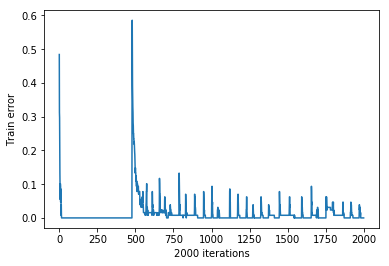

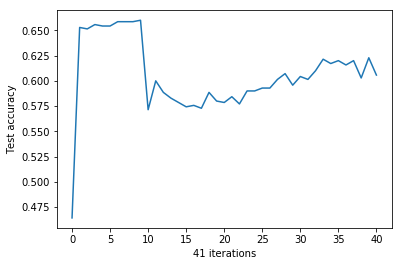

In [22]:
print("BATCH_SIZE=", BATCH_SIZE)
total_iterations = 0
train_acc = []
start_time = time.time()
train_acc_record = []
test_acc_record = []
epoch_time_record = []

best_test_acc = 0.0
last_improvement = 0
improved_str = ""
test_count = 0
mul = int(len(trainX)/BATCH_SIZE)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(EPOCHS):
        epoch_start_time = time.time()
        
        for j in range(len(x_allBatch)):
            feed_dict_train = {x: x_allBatch[j], d: y_allBatch[j]}
            sess.run(train_op, feed_dict={x: x_allBatch[j], d: y_allBatch[j]})

        train_acc_record.append(accuracy.eval(feed_dict={x: x_allBatch[j], d: y_allBatch[j]}))
        epoch_end_time = time.time()
        epoch_time_diff = epoch_end_time-epoch_start_time
        epoch_time_record.append(epoch_time_diff)

        if (i % 50 == 0 or i == (EPOCHS - 1)):
            test_count += 1
            test_accuracy = sess.run(accuracy, feed_dict={x: testX, d: testY})
            test_acc_record.append(test_accuracy)
            if DROP:
                if test_accuracy > best_test_acc:
                    best_test_acc = test_accuracy
                    last_improvement = i
                    saver.save(sess=sess, save_path=RESULT_DIR)
                    improved_str = "*"
                else:
                    improved_str = ''
            else:
                saver.save(sess=sess, save_path=RESULT_DIR)

            print('iter %d: Train accuracy %g'%(i, train_acc_record[i]), 'Test accuracy: ',test_accuracy, improved_str)
            print("Time usage: " + str(timedelta(seconds=int(round(time.time() - start_time)))))


# Ending time.
end_time = time.time()

# Difference between start and end-times.
time_dif = end_time - start_time

# Print the time-usage.
print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

train_graphName = "PartB-Q1-Train"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png"
test_graphName = "PartB-Q1-Test"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png"
plot_graph(EPOCHS, BATCH_SIZE, train_acc_record,train_graphName, isTrain = True, error=True)
plot_graph(test_count, BATCH_SIZE, test_acc_record, test_graphName, isTrain = False)


train_acc_backup.append(train_acc_record)
test_acc_backup.append(test_acc_record)
time_usage_backup.append(epoch_time_record)
total_time_backup.append(time_dif)

#=========== Save all the data for EACH TRAINING Has Done ============#
fileNameTail = str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"

train_acc_filename = "PartB-Q1-Train_Acc-"+fileNameTail
with open(os.path.join(RESULT_DIR, train_acc_filename), 'wb') as fp:
    pickle.dump(train_acc_backup, fp)

test_acc_filename = "PartB-Q1-Test_Acc-"+fileNameTail
with open(os.path.join(RESULT_DIR, test_acc_filename), 'wb') as fp:
    pickle.dump(test_acc_backup, fp)

time_usage_filename = "PartB-Q1-Time_Usage-"+fileNameTail
with open(os.path.join(RESULT_DIR, time_usage_filename), 'wb') as fp:
    pickle.dump(time_usage_backup, fp)

time_usage_filename = "PartB-Q1-Time_Usage-"+fileNameTail
with open(os.path.join(RESULT_DIR, time_usage_filename), 'wb') as fp:
    pickle.dump(time_usage_backup, fp)        
